# Transformata Fouriera dla obrazów cyfrowych. Filtracja w dziedzinie częstotliwości.

## Cel ćwiczenia

- Zapoznanie z wykorzystaniem transformaty Fouriera w przetwarzaniu obrazów cyfrowych.
- Zapoznanie z pojęciem F-obrazu (amplitudy i fazy).
- Zapoznanie z własnościami transformaty Fouriera.
- Zapoznanie z filtracją w dziedzinie częstotliwości.

Na jednym z poprzednich ćwiczeń zetknęliśmy się z pojęciem konwolucji.
Przykładem może być filtracja dolno i górnoprzepustowa.
Operacja ta odpowiada mnożeniu w dziedzinie częstotliwości zgodnie z zależnością:

\begin{equation}
\mathcal{F}(g(x,y)*h(x,y)) = \mathcal{F}(g(x,y)) \cdot \mathcal{F}(h(x,y))
\end{equation}

gdzie: $\mathcal{F}$ oznacza transformatę Fouriera, a $*$ jest splotem.

Operacja filtracji w dziedzinie częstotliwości może okazać się bardziej efektywna, jeżeli operacje $fft$ i $ifft$ (odpowiednio szybka transformata Fouriera -- *fast Fourier transform* -- oraz odwrotna szybka transformata Fouriera -- *inverse fast Fourier transform*) zajmą mniej czasu niż klasyczna konwolucja (zazwyczaj ma to miejsce dla dużego obrazu, z dużą maską).

Sama filtracja w dziedzinie częstotliwości to mnożenie punktowe całego obrazu przez jedną maskę.

W przypadku filtracji w dziedzinie częstotliwości zakłada się, że obraz "zawija się" na brzegach, co może powodować pewne artefakty (zostanie to pokazane w trakcie ćwiczenia).

W dziedzinie częstotliwości "działają" tylko filtry liniowe.
Filtry medianowe, maksymalne, minimalne itp. nie mają swoich odpowiedników.

## Dwuwymiarowa transformata Fouriera

1. Wczytaj plik "dwieFale.bmp" w skali szarości.
Jest to obraz powstały na podstawie następującej zależności:

\begin{equation}
L(m, n) = 128 + 127 \cdot \cos(\frac{2\pi m}{32}+\frac{3\pi}{4}) \cdot \cos(\frac{2\pi n}{8}-\frac{\pi}{2})
\end{equation} <br>

gdzie: $m$ i $n$ są odpowiednio numerami wierszy i kolumn.

2. Do realizacji dwuwymiarowej transformaty Fouriera służy funkcja `cv2.dft`.
Ustaw flagę `flags=cv2.DFT_COMPLEX_OUTPUT`.
Wykonaj transformatę na wczytanym obrazie.
W ten sposób uzyskuje się tzw. F-obraz.

3. Najniższe częstotliwości znajdują się w lewym-górnym rogu obrazu.
Dla celów wizualizacji (ale też przetwarzania) często wykonuje się tzw. przesunięcie F-obrazu, które powoduje, że niskie częstotliwości przesuwane są do środka obrazu.
Wykorzystaj funkcję `np.fft.fftshift`.
Jako pierwszy argument podaj wynik transformaty Fouriera.
Jako drugi argument podaj numery osi, wzdłuż których należy wykonać operację.
Pierwsza oś odnosi się do wierszy obrazu.
Druga oś odnosi się do kolumn obrazu.
Trzecia oś to część rzeczywista (`[:, :, 0]`) lub urojona (`[:, :, 1]`).
W naszym przypadku argument powinien wyglądać tak `[0,1]`.

4. Wyświetl wynik transformaty.
Na wspólnym wykresie umieść obraz oryginalny, amplitudę i fazę F-obrazu.
Amplitudę i fazę wyznacz za pomocą funkcji `cv2.cartToPolar`.
Pierwszym argumentem funkcji jest część rzeczywista wyniku, a drugim urojona.
Uwaga. W razie wątpliwości proszę sprawdzić rozmiary rezultatu transformaty Fouriera oraz przesunięcia.

5. Dla wizualizacji oblicz logarytm dziesiętny amplitudy: `ALog = np.log10(A + 1)`.
Wyświetl go zamiast amplitudy na poprzednim wykresie.

6. Wczytaj obrazy *kolo.bmp*, *kwadrat.bmp*, *kwadrat45.bmp*, *trojkat.bmp*.
Czy analizując F-obraz można coś powiedzieć o kierunku krawędzi obiektów?

7. Sprawdź (empirycznie) poprawność stwierdzenia:
>Dwuwymiarowa transformata Fouriera jest złożeniem dwóch transformat jednowymiarowych (wykonanych np. najpierw wierszowo, a później kolumnowo). Jednowymiarowa transformata realizowana jest za pomocą funkcji fft (z bibloteki Numpy).
>
Wykonaj najpierw transformatę po wierszach: `FRow = np.fft.fft(I, axis=0)`.
Następnie po kolumnach: `FCol = np.fft.fft(FRow, axis=1)`.
Numpy zwraca wynik jako tablicę liczb zespolonych.
Część rzeczywistą można otrzymać w następujący sposób: `FCol.real`, a urojoną: `FCol.imag`.
Porównaj tak uzyskany wynik z rezultatem działania funkcji `cv2.dft`.
Można to zrobić wizualnie lub z wykorzystaniem funkcji `cv2.absdiff`.

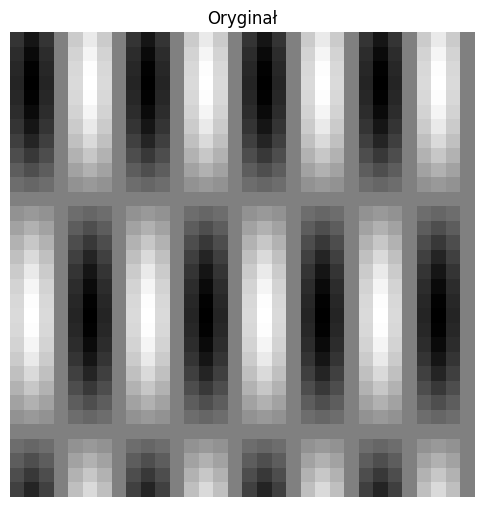

In [7]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/'

fileNames = ["dwieFale.bmp", "kolo.bmp", "kwadrat.bmp", "kwadrat45.bmp", "kwadratKL.bmp", "kwadratS.bmp", "kwadratT.bmp" ,"lena.bmp", "trojkat.bmp", "literki.bmp", "wzorA.bmp"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

I_Fale = cv2.imread('dwieFale.bmp', cv2.IMREAD_GRAYSCALE)

def plots(**kwargs):

    n = len(kwargs)
    fig, axes = plt.subplots(((n - 1) // 3) + 1, np.min([3, n]))
    fig.set_size_inches(np.min([n * 6, 20]), (((n - 1) // 3) + 1) * 8)
    i = 0

    for key, image in kwargs.items():
        if n == 1:
            axes.imshow(image, "gray")
            axes.axis("off")
            axes.set_title(key)
        elif n <= 3:
            axes[i].imshow(image, "gray")
            axes[i].axis("off")
            axes[i].set_title(key)
        elif n > 3:
            axes[i // 3, i % 3].imshow(image, "gray")
            axes[i // 3, i % 3].set_title(key)
        i += 1

    if n > 1:
        for ax in axes.flat:
            ax.axis("off")

    plt.show()

images = {}
images["Oryginał"] = I_Fale

plots(**images)

(32, 32) (32, 32)


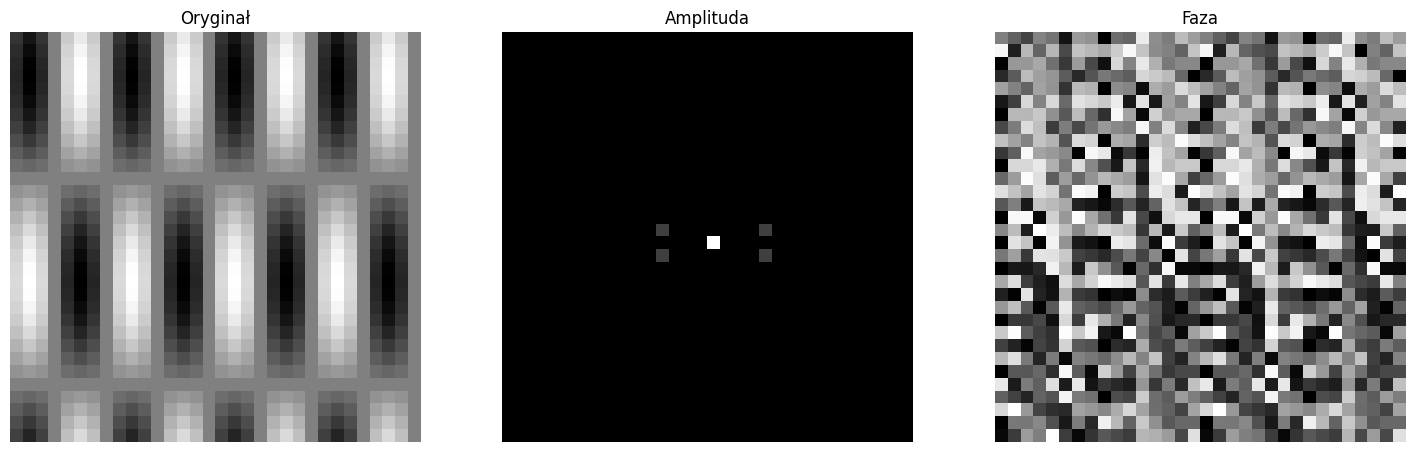

In [12]:
fourier = cv2.dft(src=np.float32(I_Fale), flags=cv2.DFT_COMPLEX_OUTPUT)

f_Image = np.fft.fftshift(x=fourier, axes=[0,1])

amplitude, phase = cv2.cartToPolar(f_Image[:, :, 0], f_Image[:, :, 1])
print(amplitude.shape, phase.shape)

images["Amplituda"] = amplitude
images["Faza"] = phase

plots(**images)

## Własności dwuwymiarowej transformaty Fouriera

1. Zbadaj jak zmienia się F-obraz (amplituda i faza) podczas następujących operacji: translacja, rotacja, zmiana rozmiaru, kombinacja liniowa.
Wykorzystaj stworzony wcześniej kod.<br>
Uwaga. Należy użyć przygotowanych obrazów, a nie "generować" własne.
2. Do badania translacji wykorzystaj obrazy *kwadrat.bmp* i *kwadratT.bmp*.
3. Przy badaniu rotacji wykorzystaj obrazy *kwadrat.bmp* i *kwadrat45.bmp*.
4. Przy badaniu zmiany rozmiaru wykorzystaj obrazy *kwadrat.bmp* i *kwadratS.bmp*.
5. Przy badaniu kombinacji liniowej wykorzystaj obrazy *kwadrat.bmp*, *kwadrat45.bmp* i *kwadratKL.bmp*.

## Odwrotna dwuwymiarowa transformata Fouriera

1. Wykorzystaj stworzony wcześniej kod. Wybierz dowolny obraz np "kolo.bmp".
2. Przed realizacją odwrotnego przekszałcenia należy wykonać odwrotne przesunięcie.
Wykorzystaj funkcję `np.fft.ifftshift`.
Pierwszym argumentem jest wynik transformaty Fouriera.
Drugim argumentem są numery osi, wzdłuż których należy wykonać operację.
3. Wykonaj odwrotną transformatę Fouriera za pomocą funkcji `cv2.idft`.
Jako drugi argument przekaż następujące flagi: `flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT`.
Wynik może mieć małą część urojoną przez błędy numeryczne.
Aby pozbyć się tego efekty należy obliczyć amplitudę:
        imgIFFT = cv2.magnitude(ifft[:, :, 0], ifft[:, :, 1])
Następnie wynik należy zaokrąglić (`np.round`) i zrzutować do typu `uint8`.
4. Wyświetl wynik.
Sprawdź (wizualnie i poprzez odjęcie) czy obraz oryginalny i po przekształceniach są takie same.

## Filtracja obrazu w dziedzinie częstotliwości

1. Wczytaj obraz "lena.bmp" w skali szarości.
Wykonaj transformatę Fouriera.
Wykorzystaj stworzony poprzednio kod.
Wyświetl obraz oryginalny, amplitudę (w skali logarytmicznej) i fazę.

2. Przeprowadź filtrację dolnoprzepustową - usuń górne częstotliwości.
Dla F-obrazu po operacji przesunięcia (`fftshift`) niskie częstotliwości leżą w jego centrum.

3. Na początku stwórz filtr "kołowy", dolnoprzepustowy.
Należy wygenerować macierze opisujące przestrzeń w dziedzinie częstotliwości.
Ich rozmiar musi być taki sam jak rozmiar przetwarzanego obrazu.
        lenaSize = I_Lena.shape
        FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(lenaSize[0]))
        FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, lenaSize[1]]))
        FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(lenaSize[1]))
        FSpaceColsM = np.outer(np.ones([1, lenaSize[0]]), FSpaceCols)
Powyższy kod wygeneruje dwie znormalizowane macierze częstotliwości: *FSpaceRowsM* i *FSpaceColsM*.
Następnie należy wyznaczyć macierz zawierającą "odległość" od składowej stałej.
        FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

Uwagi:
- funkcja `fftfreq` generuje wektor częstotliwości $[-0.5, 0.5]$ o określonym rozmiarze, przy czym układ wartości jest taki, że najpierw od 0 do 0.5, a potem od -0.5 do 0,
- operacja `fftshift` zmienia ten układ na $[-0.5, 0.5]$,
- mnożenie przez 2 ustala ostatecznie zakres na $[-1, 1]$,
- operacja `outer` to tzw. iloczyn zewnętrzy dwóch wektorów, w naszym przypadku powoduje, że wektor pionowy lub poziomy jest "powielany" odpowiednią liczbę razy.   
- sugeruje się, aby przyglądnąć się jak wygląda macierz `FreqR` - czy to w debugerze, czy poprzez wizualizację.

4. Teraz należy wybrać interesujący zakres.
Tu można zdefiniować typ filtru (dolno, górno, pasmowoprzepustowy).

        FilterF = FreqR <= 0.1

Filtr należy zwizualizować:

        figFilter = plt.figure()
        axsFilter = figFilter.add_subplot(projection='3d')
        axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterF, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
        figFilter.show()

4. Wykonaj właściwą filtrację, czyli mnożenie F-obrazu przez filtr FilterF.
Trzeba pamiętać, że F-obraz ma 2 kanały (rzeczywisty i urojony).
By mnożenie było możliwe należy więc powielić filtr również na 2 kanały.

        FilterF3 = np.repeat(FilterF[:, :, np.newaxis], 2, axis=2)

5. Wykonaj operację odwrotnego przesunięcia i odwrotnej transformaty.
Oblicz wartość bezwzględną wyniku.
Wykorzystaj funkcję `cv2.magnitude`.
Pierwszym argumentem jest część rzeczywista.
Drugim argumentem jest część urojona.
Wynik wyświetl.

6. Poeksperymentuj z rozmiarem filtru (promieniem).
Zaimplementuj filtr górnoprzepustowy (zmiana znaku przy warunku na odległość) oraz pasmowoprzepustowy (dwa warunki na promień połączone operatorem AND '&' ).
Wykonaj co najmniej trzy filtry i wyświetl wyniki.

7. W ten sposób zaimplementowana filtracja wprowadza pewne artefakty w postaci "pierścieni" wokół krawędzi.
Zapobiec temu zjawisku można poprzez odpowiednie "modelowanie" filtra.
W tym celu wykorzystać należy okna, np. Hamminga, Hanninga, Chebysheva (znane z przetwarzania sygnałów 1D).
Zagadnienie to jest tematem zadania domowego do tego ćwiczenia.

## Implementacja wyszukiwania wzorca za pomocą FFT

1. Wczytaj w skali szarości i wyświetl obrazy *literki.bmp* i *wzorA.bmp*.

2. Wyznacz transformatę Fouriera obrazu *literki.bmp*.

3. Obróć drugi obraz o $180^\circ$.
Zastosuj funkcję `np.rot90`.
Pierwszym argumentem jest obracana macierz, a drugim liczba obrotów o $90^\circ$.

4. Należy wyznaczyć transformatę Fouriera obróconego obrazu w taki sposób, żeby miała ona taki sam rozmiar jak pierwszy obraz.
W tym celu należy zastosować *Zero Padding*.
Operacja ta polega na uzupełnieniu obrazu zerami do oczekiwanego rozmiaru.
Uzupełnij obraz zerami z **prawej** strony i z **dołu**.
W tym celu należy wykorzystać funkcję `cv2.copyMakeBorder`.
    - Pierwszym argumentem jest obraz wejściowy.
    - Drugim argumentem jest liczba wierszy u góry.
    - Trzecim argumentem jest liczba wierszy u dołu.
    - Czwartym argumentem jest liczba kolumn z lewej.
    - Piątym argumentem jest liczba kolumn z prawej.
    - Szóstym argumentem jest flaga typu wypełnienia.
    Dla stałej wartości podaj `cv2.BORDER_CONSTANT`.
    - Siódmym argementem jest wartość pikseli w ramce.
    Przekaż `value=0`.

5. Wyznacz transformatę Fouriera obrazu stworzonego w poprzednim punkcie.

6. Wyniki obu transformat należy przekonwertować do liczb zespolonych.
Obecnie jest to dwukanałowa macierz.
Pierwszy kanał odpowiada za część rzeczywistą.
Drugi kanał odpowiada za część urojoną.
Aby to osiągnąć wystarczy wykonać działanie:
        Complex = Real + Imag * 1j

7. Przemnóż ze sobą zespolone wyniki transformat.

8. Wynik należy powrotnie przekształcić do dwukanałowej macierzy.
Aby to zrobić wykonaj operację:
        CompMat = cv2.merge([np.real(Complex), np.imag(Complex)])

9. Wykonaj odwrotną transformatę Fouriera.
Dodaj flagę `flags=cv2.DFT_COMPLEX_INPUT`.

10. Oblicz wartość bezwzględną wyniku.

11. Wykonaj morfologiczną operację **Top-Hat**, by znaleźć maksima lokalne.
Operacja ta zostanie dokładnej wyjaśniona w jednym z kolejnych ćwiczeń.
W tym celu wykorzystaj operację:
        cv2.morphologyEx(correlation, cv2.MORPH_TOPHAT, np.ones((3, 3), np.uint8))

12. Wyświetl obok siebie obraz wejściowy i wynik wykonanych operacji.
Czy możesz wskazać położenie wzoru na podstawie drugiego obrazu?